# Задание 1

Приложение - мобильная утилита для сканирования документов. Модель монетизации подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю. Каждая строка представляет собой отдельное событие (либо оформление пробной подписки, либо оплата после завершения пробного периода). Задание построено таким образом, чтобы проверить понимание принципов unit-экономики предприятия. Задание 1 предпочтительней делать с помощью Python.

1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

## Мой комментарий к заданию
- Не очень понятен смысл фразы "когорта представляет собой кол-во возможных операций". Когорта - группа пользователей, объединенных каким-то действием в заданный период времени, как это может быть кол-во операций? Если бы была возможность, этот момент нужно было бы уточнить.
- Я выбрал недельные когорты пользователей, оплативших пользование утилитой, недеюсь, это и подразумевалось.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

In [2]:
df=pd.read_excel('test_case.xlsx')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657
...,...,...,...,...,...
114195,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8291100
114196,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-02,8236936
114197,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-03,8247910
114198,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-04,8294146


In [3]:
print('Строк-дубликатов {}'.format (df.duplicated().sum()))
print('Пропусков {}'.format(df.isna().sum()))
df = df.drop_duplicates()
df = df.dropna()

Строк-дубликатов 84
Пропусков product_id         0
quantity           0
is_trial_period    0
purchase_date      0
user_id            0
dtype: int64


Обнаружено 84 дубликата, дубликаты удалены.
Пропусков нет.

In [4]:
# так как мы считаем LTV, а за пробный период оплату не получаем, возьмем только оплаченные периоды пользования
df = df.query('is_trial_period == False')

# посмотрим диапазон дат, чтобы решить, какие когорты взять
display(df['purchase_date'].min())
display(df['purchase_date'].max())

Timestamp('2020-01-01 00:00:00')

Timestamp('2020-02-20 00:00:00')

In [5]:
# учитывая еженедельную оплату, берем недельные когорты
# из последней недели у нас попал всего один день, поэтому к значениям последних когорт будем относиться аккуратно
df['purchase_week'] = df['purchase_date'].dt.isocalendar().week
first_orders = df.groupby('user_id').agg({'purchase_week': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_purchase_week']

month_orders = (
        df.groupby(['user_id', 'purchase_week'])
        .agg({'quantity': 'sum'})
        .reset_index()
    )

table_join = pd.merge(month_orders, first_orders, on='user_id', how='left').reset_index()

In [6]:
cohorts_size = table_join.groupby('first_purchase_week').agg({'user_id': 'nunique'}).reset_index()
cohorts_size.columns = ['first_purchase_week', 'n_buyers']

cohorts_orders = table_join.groupby(['purchase_week', 
                                     'first_purchase_week']).agg({'quantity': 'sum'}).reset_index()
cohorts_orders = pd.merge(cohorts_size, cohorts_orders, on = 'first_purchase_week')

cohorts_orders['age'] = cohorts_orders['purchase_week'] - cohorts_orders['first_purchase_week']
cohorts_orders['ltv'] = cohorts_orders['quantity'] * 4.99 / cohorts_orders['n_buyers']

# так как по заданию "стоимость привлечения платящего пользователя 6 USD", мы продолжаем рассматривать
# только платящих пользователей, посчитаем ROMI по когортам
cohorts_orders['romi'] = cohorts_orders['ltv'] / 6

output = cohorts_orders.pivot_table(
    index='first_purchase_week', columns='age', values='ltv', aggfunc='mean'
    ).cumsum(axis=1).round(2)
print('Средний LTV пользователя по всем когортам на конец наблюдений равен {} USD'.format(
    round(output.mean(axis = 1).mean()), 2)
     )
output.fillna('-')

Средний LTV пользователя по всем когортам на конец наблюдений равен 10 USD


age,0,1,2,3,4,5,6,7
first_purchase_week,,,,,,,,
1,4.99,8.98,11.98,13.97,14.97,16.97,18.96,19.96
2,4.99,8.85,12.19,15.18,17.9,20.36,20.91,-
3,4.99,8.81,12.04,14.85,17.43,18.52,-,-
4,4.99,8.67,11.76,14.45,15.61,-,-,-
5,4.99,8.47,11.33,12.61,-,-,-,-
6,4.99,8.45,9.81,-,-,-,-,-
7,4.99,6.63,-,-,-,-,-,-
8,4.99,-,-,-,-,-,-,-


 - Текущий LTV пользователя первой когорты составляет 19.96 USD
 - Текущий LTV среднего пользователя пользователя составляет 10.00 USD

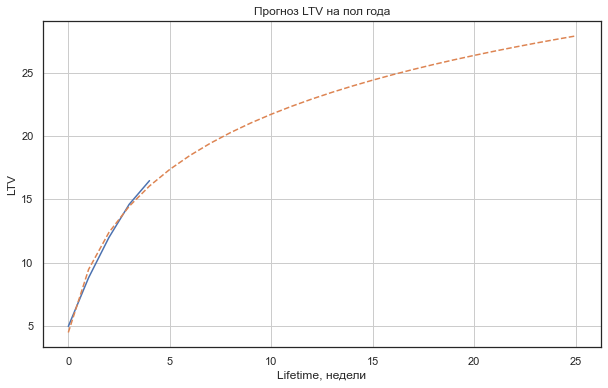

,week_number,LTV
0,1,4.511245
1,2,9.483638
2,3,12.392302
3,4,14.456031
4,5,16.056784
5,6,17.364695
6,7,18.470518
7,8,19.428425
8,9,20.273359
9,10,21.029178


In [18]:
# для расчета прогнозируемого LTV, возьмем первые 5 когорт за первые 5 недель
output = cohorts_orders.query(('first_purchase_week <= 4 and age <=4')).pivot_table(
    index='first_purchase_week', columns='age', values='ltv', aggfunc='mean'
    ).cumsum(axis=1).round(2)

#рассчитаем среднее значение LTV на каждой неделе
df = output.reset_index(drop=True)
df_mean = df.mean(axis = 0)

#вычислим коэффициенты логарифмической функции и экстраполируем:
def func(x, a, b):
    return a*np.log(x)+b

x =  range(1,6)
y = [4.9900, 8.8275, 11.9925, 14.6125, 16.4775]

popt, pcov = opt.curve_fit(func, x, y)

# пол года  -  это 26 недель
x1 = range(1, 27)

#построим график LTV и прогноза
plt.figure(figsize=(10, 6))
plt.plot(df_mean)
plt.plot(func(x1, *popt), "--")
plt.grid(True)
plt.ylabel('LTV')
plt.xlabel('Lifetime, недели')
plt.title('Прогноз LTV на пол года')
plt.show()

#прогноз LTV на пол года
ltv_forecast = pd.DataFrame({'week_number': x1, 'LTV': func(x1, *popt)})
ltv_forecast

## Расчет ROMI

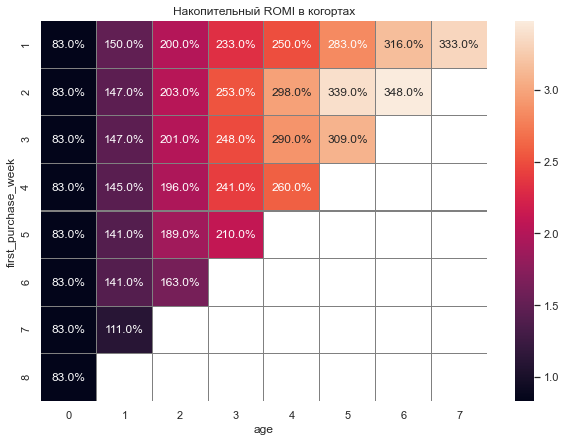

Средний ROMI на 4ую неделю составляет 237.0%
Прогнозируемый ROMI на пол года составляет 469.2%


In [8]:
output2 = cohorts_orders.pivot_table(
    index='first_purchase_week', columns='age', values='romi', aggfunc='mean'
    )

sns.set(style='white')
plt.figure(figsize=(10, 7))
plt.title('Накопительный ROMI в когортах')
sns.heatmap(output2.cumsum(axis=1).round(2), annot=True, fmt='.1%', linewidths=0.1, linecolor='gray')
plt.show()

print('Средний ROMI на 4ую неделю составляет {:.1%}'.format(
    output2.cumsum(axis=1).round(2).reset_index(drop=True)[3].mean())
     )
#Для вычисления прогнозируемого ROMI воспользуемся рассчитаным прогнозом для LTV
print('Прогнозируемый ROMI на пол года составляет {:.1%}'.format(func(27, *popt)/6))

## Выводы
1. Текущий LTV среднего пользователя пользователя составляет 10.00 USD. Текущий LTV пользователя первой когорты составляет 19.96 USD.
2. Прогноз LTV на пол года выполнен.
3. График фактического и прогнозируемого LTV построен.
4. Средний ROMI на 4ую неделю составляет 237.0%
Прогнозируемый ROMI на пол года составляет 469.2%

# Задание 2

## Задание 2.1
Написать 2 SQL запроса для поиска значений среднего и медианы по сумме продажи. Сумму транзакции округляем до целой части. Нельзя использовать стандартные функции среднего и медианы в SQL. Можно использовать только агр функции SUM и COUNT.
  
Схема данных: 

`● orders
○ id
○ sale_amount - в центах 
○ user_id
○ datetime`

### Решение 2.1.1
`"""
SELECT
SUM(sale_amount)/COUNT(sale_amount) as avg_sale_amount
FROM orders
"""`

### Решение 2.1.2
`""
SELECT ROUND(SUM(sale_amount)/COUNT(sale_amount), 0) as median_sale_amount
FROM  
(SELECT sale_amount, 
      ROW_NUMBER() OVER (ORDER BY sale_amount) AS rows_asc,
      ROW_NUMBER() OVER (ORDER BY sale_amount DESC) AS rows_desc
   FROM orders) AS a
WHERE rows_asc BETWEEN rows_desc - 1 AND rows_desc + 1
"""`


Если можно использовать PERCENTILE_CONT, то лучше так:

`""SELECT PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY sale_amount) 
FROM orders"
"""`

## Задание 2.2 
Написать SQL-запрос для поиска задублированных в результате ошибки транзакций.
Схема данных: 

`● purchases
○ transaction_id
○ datetime 
○ amount 
○ user_id`


## Решение 2.2
`"""
SELECT transaction_id, amount
FROM purchases
GROUP BY transaction_id, amount
HAVING (COUNT(*) > 1)
"""`

## Задание 2.3
Написать SQL-запрос для построения воронки перехода из установки в оформление пробного периода и в покупку платной версии приложения в разрезе стран. На одного юзера возможна только одно оформление пробного периода и одна покупка платной версии. Покупка возможна только после истечения срока пробного периода. На выходе должна получится таблица с колонками “country”, “installs”, “trials”, “purchases”, “conversion_rate_to_trial”, “conversion_rate_to_purchase”

Схема данных: 

`● events
○ transaction_id
○ datetime
○ event_type (значение может быть либо “instal”, либо “trial”, либо “purchase”) 
○ user_id
○ country`

### Решение 2.3

In [25]:
query = """
WITH inst as (SELECT 
country,
COUNT(event_type) as installs
FROM events
WHERE event_type = 'install'
GROUP BY country), 

tr as (SELECT 
country,
COUNT(event_type) as trials
FROM events
WHERE event_type = 'trial'
GROUP BY country),

purch as (SELECT 
country,
COUNT(event_type) as purchases
FROM events
WHERE event_type = 'purchase'
GROUP BY country)

SELECT
*, 
a.trials / a.installs as conversion_rate_to_trial,
a.purchases / a.trials as conversion_rate_to_purchase
FROM
(SELECT 
events.country as country,
inst.installs as installs,
tr.trials as trials,
purch.purchases as purchases
FROM
events
JOIN inst on events.country = inst.country
JOIN tr on inst.country = tr.country
JOIN purch on inst.country = purch.country
GROUP BY events.country, inst.installs, tr.trials, purch.purchases) as a
"""

# Задание 3

Продуктовый менеджер сформировал гипотезу, что новая версия экрана продаж будет лучше перформить по сравнению со старой, в связи с тем, что на новом экране продаж более понятно описаны преимущества платной версии приложения.
Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупку платной версии приложения. Приложение тем временем уже очень активно продвигается на рынке, каждый день привлекается в среднем по 30 000 новых пользователей, текущий уровень конверсии из установки в покупку 5%.
Как бы вы предложили проверить данную гипотезу, какие инструменты и тесты бы использовали в процессе проверки?

## Решение 3

До проверки гипотезы, нужно оценить ее, используя zero-code инструменты. Можно провести приоретизацию гипотез методом RICE (ICE). Ведь выкатить новый экран - это время разработчиков, а значит деньги, проверить гипотезу - время аналитиков, тоже деньги. Если оценка проведена и принято решение действительно проверять гипотезу, двигаемся дальше.

Для проверки гипотезы о том, что новая верия экрана продаж дает лучшую конверсию из установки в покупку платной версии приложения, я бы провел А/А/В тестирование, выделив две схожие группы пользователей. В одной группе показывали бы новый экран продаж, во второй старый. Сравнил бы, есть ли статистическая значимые различия между конверсиями в группах.

Минимальный размер выборки для наблюдения 95% значимости изменения конверсии при текущем уровне в 5% - 120 146 пользователей. 
Нужно провести z-test для проверки гипотезы о статистически значимом различии между конверсиями в группах А и В. Уровень стат значимости 5%.
Во время теста нужно учесть:
- будние и выходные дни
- праздники
- отсутствие акций и маркетинговых активностей
- активность конкурентов в этот момент
- цикл реализации конверсии - какое время принятия решения о покупке - от установки до покупки.